In [ ]:
# BURAK TURGUT

In [ ]:
!nvidia-smi

Fri Feb  3 18:30:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, InputLayer, Reshape, MaxPooling2D, Flatten

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
malaria_data=os.listdir('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train')
print(malaria_data)

parasitized=os.listdir('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train/Parasitized')
print(parasitized[:2])

uninfected=os.listdir('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train/Uninfected')
print(uninfected[:2])

['Parasitized', 'Uninfected']
['C93P54ThinF_IMG_20150821_163640_cell_197.png', 'C99P60ThinF_IMG_20150918_140900_cell_147.png']
['C88P49ThinF_IMG_20150820_151451_cell_61.png', 'C78P39ThinF_IMG_20150606_104426_cell_18.png']


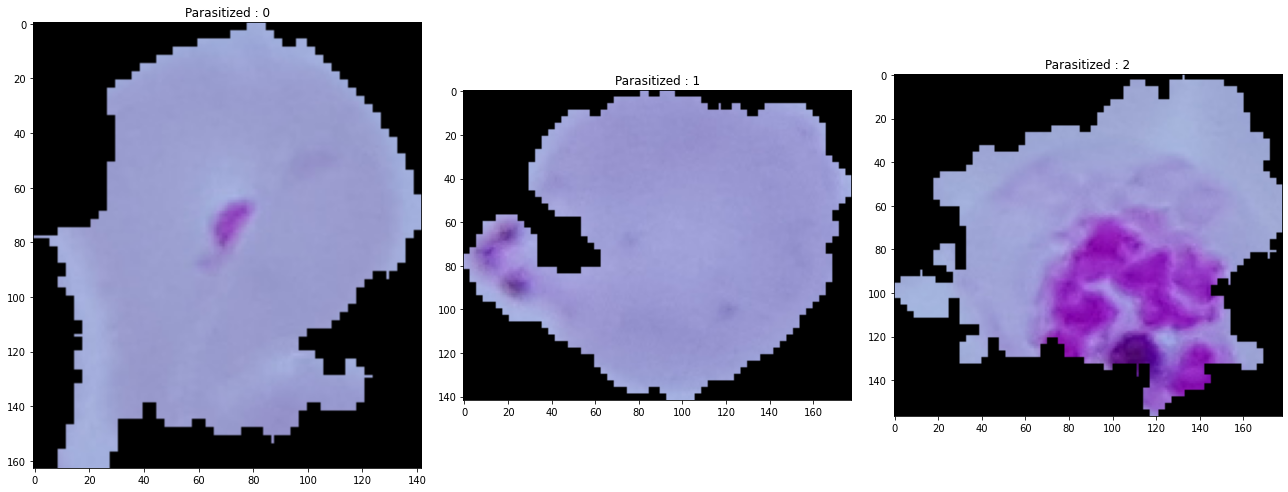

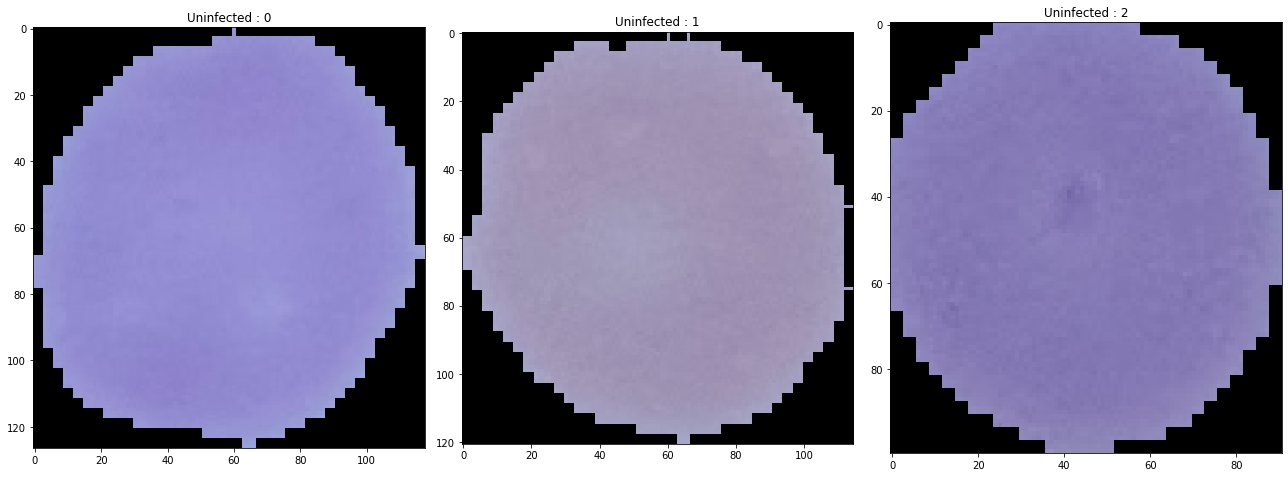

In [ ]:
# Parasitized sınıfından 3 örnek
plt.figure(figsize = (18,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img = cv2.imread('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train/Parasitized' + "/" + parasitized[i])
    plt.imshow(img)
    plt.title('Parasitized : {i}'.format(i=i))
    plt.tight_layout()
plt.show()

# Uninfected sınıfından 3 örnek
plt.figure(figsize = (18,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img = cv2.imread('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train/Uninfected' + "/" + uninfected[i])
    plt.imshow(img)
    plt.title('Uninfected : {i}'.format(i=i))
    plt.tight_layout()
plt.show()

In [ ]:
data = []
labels = []

In [ ]:

for img in parasitized:
    try:
        img_read = plt.imread('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train/Parasitized' + "/" + img)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None


In [ ]:
for img in uninfected:
    try:
        img_read = plt.imread('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train/Uninfected' + "/"+ img)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

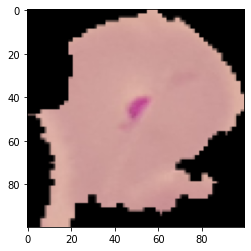

In [ ]:
plt.imshow(data[0])
plt.show()

In [ ]:
print(labels[0]) # parasitized sınıfı için çıktı 1 olmalı

1


In [ ]:
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, InputLayer, Reshape, MaxPooling2D, Flatten
from keras.layers import Dropout
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras import layers

In [ ]:
cell_images = pathlib.Path('/content/gdrive/MyDrive/malaria_cell_images/cell_images/train')

In [ ]:
# Train Dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    cell_images,
    batch_size=256,
    image_size=(100, 100),
    seed=123,
    validation_split=0.2,
    subset='training',
)

Found 22046 files belonging to 2 classes.
Using 17637 files for training.


In [ ]:
# Validation Dataset
val_data = tf.keras.utils.image_dataset_from_directory(
    cell_images,
    batch_size=256,
    image_size=(100, 100),
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 22046 files belonging to 2 classes.
Using 4409 files for validation.


In [ ]:
classes = train_data.class_names
print(classes)

['Parasitized', 'Uninfected']


In [ ]:
classes = val_data.class_names
print(classes)

['Parasitized', 'Uninfected']


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteF731PB/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer="adam",metrics="accuracy") #  binary classification problem

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0

In [ ]:
tf.keras.backend.clear_session() # clear cache

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
69/69 [==============================] - 49s 223ms/step - loss: 0.6901 - accuracy: 0.5608 - val_loss: 0.6456 - val_accuracy: 0.6181
Epoch 2/20
69/69 [==============================] - 4s 64ms/step - loss: 0.5801 - accuracy: 0.7011 - val_loss: 0.5303 - val_accuracy: 0.7659
Epoch 3/20
69/69 [==============================] - 4s 60ms/step - loss: 0.3865 - accuracy: 0.8381 - val_loss: 0.2216 - val_accuracy: 0.9102
Epoch 4/20
69/69 [==============================] - 4s 60ms/step - loss: 0.2100 - accuracy: 0.9256 - val_loss: 0.1730 - val_accuracy: 0.9322
Epoch 5/20
69/69 [==============================] - 4s 60ms/step - loss: 0.1674 - accuracy: 0.9410 - val_loss: 0.1604 - val_accuracy: 0.9410
Epoch 6/20
69/69 [==============================] - 4s 60ms/step - loss: 0.1501 - accuracy: 0.9473 - val_loss: 0.1459 - val_accuracy: 0.9524
Epoch 7/20
69/69 [==============================] - 4s 60ms/step - loss: 0.1436 - accuracy: 0.9522 - val_loss: 0.1381 - val_accuracy: 0.9565
Epoch 8/20


In [ ]:
model.save("malara_classification.h5")

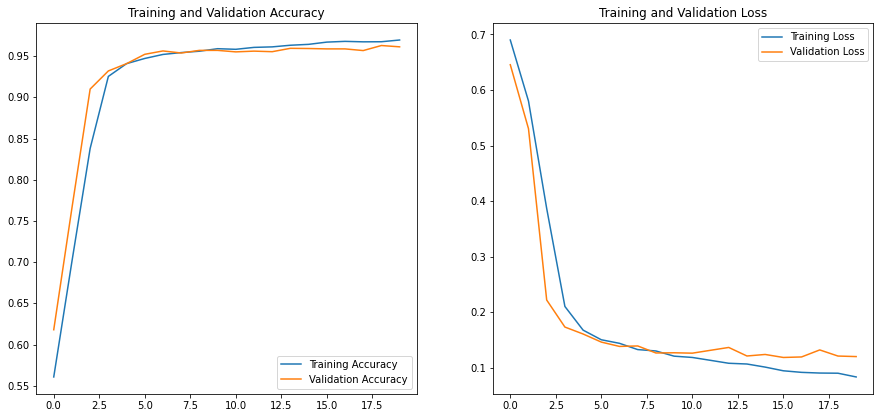

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
_,accuracy=model.evaluate(val_data)

18/18 [==============================] - 1s 29ms/step - loss: 0.1198 - accuracy: 0.9614
